In [1]:
%matplotlib inline

import subprocess

from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from matplotlib import ticker

In [2]:
seed = 418
dirname = 'distributions'
fnames = glob('../%s/*.dist' % (dirname,))

In [3]:
data_file = "aldr-alias-performance-data.txt"
methods, method_names = zip(
    ("aldr.flat.osrng", "ALDR (C, OsRng)"),
    ("aldr.enc.osrng", "ALDR (Enc, OsRng)"),
    ("fldr.flat.osrng", "FLDR (C, OsRng)"),
    ("fldr.enc.osrng", "FLDR (Enc, OsRng)"),
    ("aldr.flat", "ALDR (C)"),
    ("aldr.enc", "ALDR (Enc)"),
    ("fldr.flat", "FLDR (C)"),
    ("fldr.enc", "FLDR (Enc)"),
    ("alias.c", "Alias (C)"),
    ("alias.c.osrng", "Alias (C, OsRng)"),
    ("alias.rust", "Alias (ThreadRng)"),
    ("alias.rust.osrng", "Alias (OsRng)"),
    ("aldr.rust", "ALDR (ThreadRng)"),
    ("aldr.rust.osrng", "ALDR (OsRng)"),
)
rust_methods, rust_method_names = zip(
    *((methods[i], method_names[i]) for i in range(len(methods)) if methods[i].split('.')[1] == "rust")
)
c_methods, c_method_names = zip(
    *((methods[i], method_names[i]) for i in range(len(methods)) if methods[i] not in rust_methods)
)
if False:
    data=[]
    for method in methods:
        for fname in fnames:
            command = ["../rust/aldr/target/release/aldr", method, fname] \
                if method.split('.')[1] == "rust" else \
                ["../c/main.out", method, fname]
            # run the command only on CPU 0 (good with isolcpus=0)
            s=subprocess.run(["taskset","0x1",*command], capture_output=True)
            _, preproc_time_cold, preproc_time_warm, sample_time, flips, num_bytes = s.stdout.decode().split()
            preproc_time_cold = float(preproc_time_cold)
            preproc_time_warm = float(preproc_time_warm)
            sample_time = float(sample_time)
            flips = float(flips)
            num_bytes = int(num_bytes)
            data.append((fname, method, preproc_time_cold, preproc_time_warm, sample_time, flips, num_bytes))
    np.savetxt(data_file, data, fmt='%s')
text_data = np.loadtxt(data_file, dtype=str)
data = []
for fname, method, preproc_time_cold, preproc_time_warm, sample_time, flips, num_bytes in text_data:
    preproc_time_cold = float(preproc_time_cold)
    preproc_time_warm = float(preproc_time_warm)
    sample_time = float(sample_time)
    flips = float(flips)
    num_bytes = int(num_bytes)
    data.append((fname, method, preproc_time_cold, preproc_time_warm, sample_time, flips, num_bytes))

In [4]:
def getn(f):
    return int(f.split('/')[-1].split('.')[1])
def getm(f):
    return int(f.split('/')[-1].split('.')[2])

In [5]:
Ns = sorted(set([getn(f) for f in fnames]))
Ms = sorted(set([getm(f) for f in fnames]))
selections = Ms # [1000, 10000, 1000000]
Ms_plot = [b for b in Ms if b in selections]
size_inches = (18, 4)

In [6]:
plt.rcParams['text.usetex'] = True     # Enable LaTeX rendering
plt.rcParams['font.family'] = 'serif'  # Use serif fonts for text.
plt.rcParams['text.latex.preamble'] = r'\usepackage{newtxtext}'
# Manually change the text only to Times using text.latex.preamble.
# We do not use \usepackage{newtxmath} to keep the Computer Modern mathematics fonts.
# If we use plt.rcParams['font.serif'] = 'Times', then the math font will no longer
# be Computer Modern, which is not consistent with IEEEtran.cls
# https://matplotlib.org/stable/users/explain/text/usetex.html

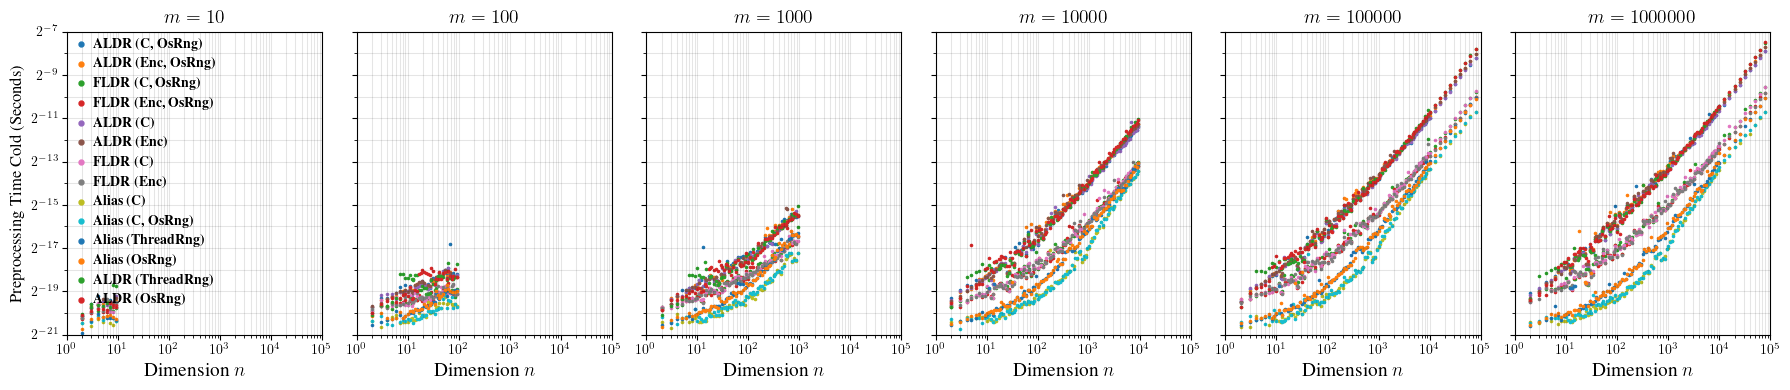

In [7]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in method_names]
    for i in range(len(methods)):
        ax.scatter(*zip(*((getn(d[0]),d[2]) for d in C if d[1] == methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=10)
    ax.set_ylim([2**-21, 2**-7])
    ax.set_xlim([10**0, 1*10**5])

    ax.set_xlabel('Dimension $n$', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Preprocessing Time Cold (Seconds)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(-.05, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(1, 10)*.1, numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

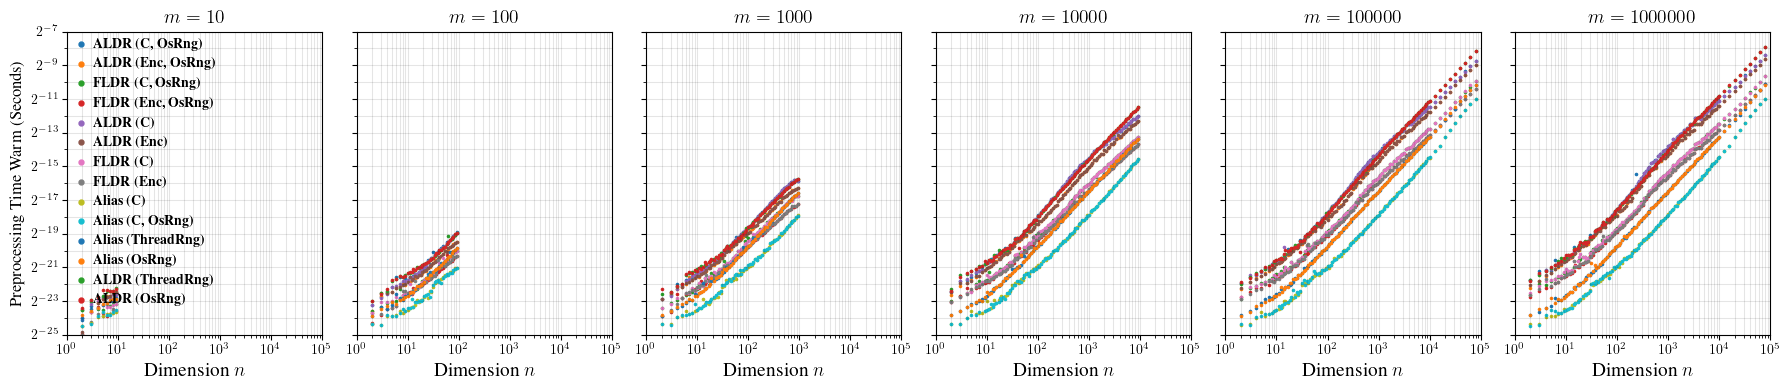

In [8]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in method_names]
    for i in range(len(methods)):
        ax.scatter(*zip(*((getn(d[0]),d[3]) for d in C if d[1] == methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=10)
    ax.set_ylim([2**-25, 2**-7])
    ax.set_xlim([10**0, 1*10**5])

    ax.set_xlabel('Dimension $n$', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Preprocessing Time Warm (Seconds)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(-.05, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(1, 10)*.1, numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

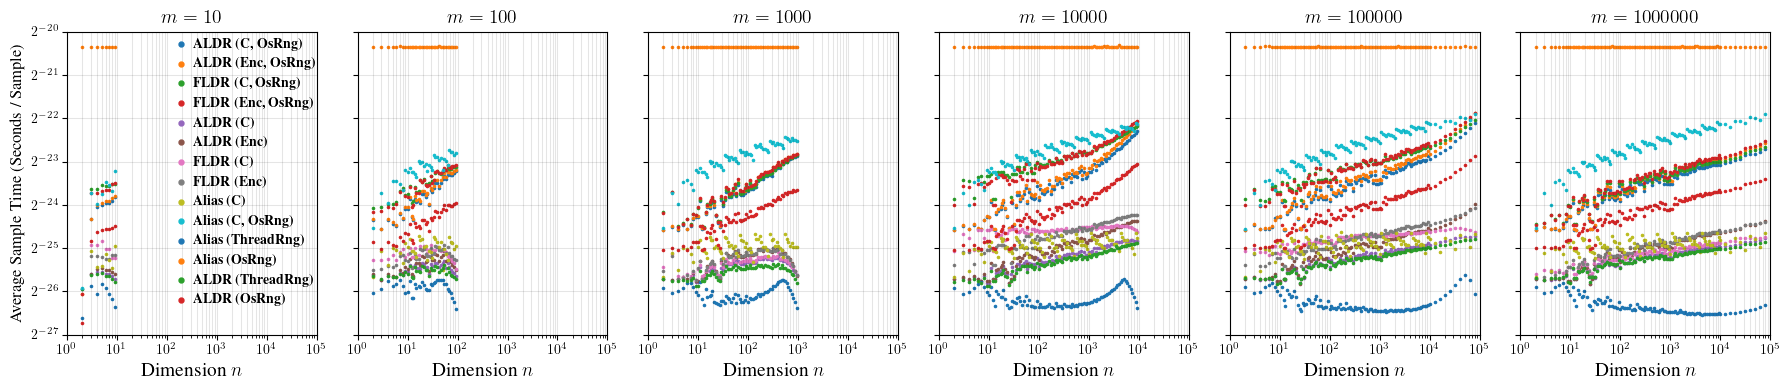

In [9]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in method_names]
    for i in range(len(methods)):
        ax.scatter(*zip(*((getn(d[0]),d[4]) for d in C if d[1] == methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=10)
    ax.set_ylim([2**-27, 2**-20])
    ax.set_xlim([10**0, 1*10**5])

    ax.set_xlabel('Dimension $n$', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Average Sample Time (Seconds / Sample)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(.35, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(1, 10)*.1, numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

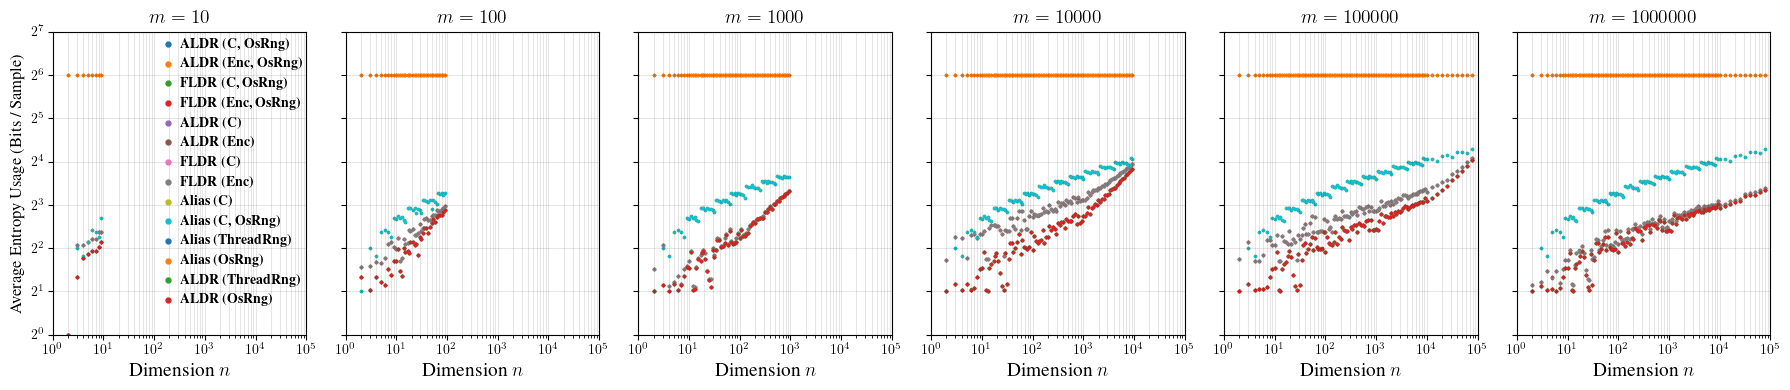

In [10]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in method_names]
    for i in range(len(methods)):
        ax.scatter(*zip(*((getn(d[0]),d[5]) for d in C if d[1] == methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=10)
    ax.set_ylim([2**0, 2**7])
    ax.set_xlim([10**0, 1*10**5])

    ax.set_xlabel('Dimension $n$', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Average Entropy Usage (Bits / Sample)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(.35, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(1, 10)*.1, numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

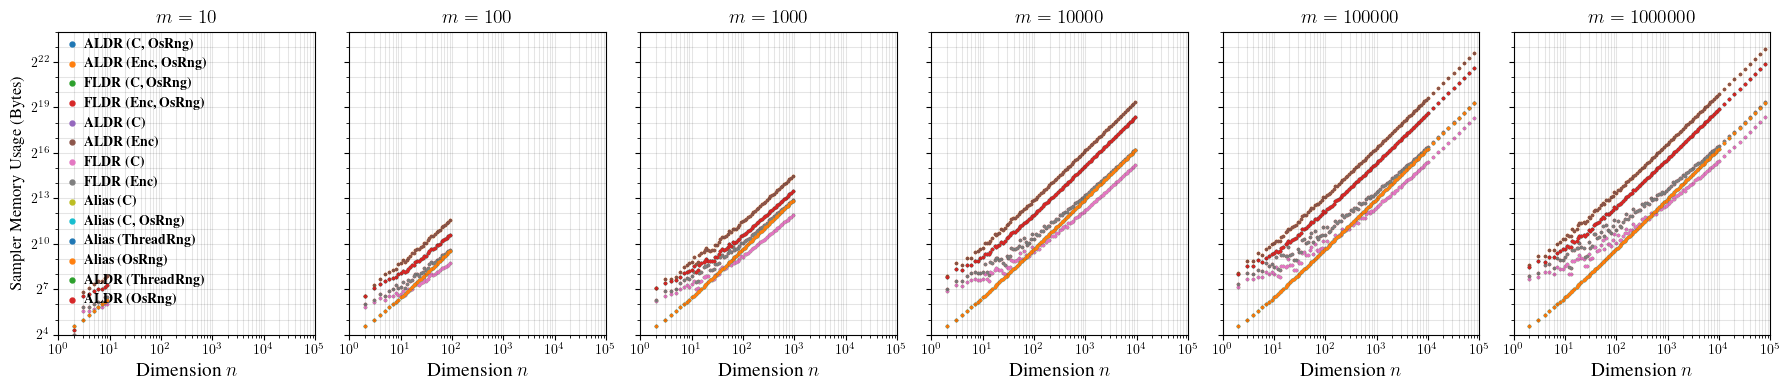

In [11]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in method_names]
    for i in range(len(methods)):
        ax.scatter(*zip(*((getn(d[0]),d[6]) for d in C if d[1] == methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=10)
    ax.set_ylim([2**4, 2**24])
    ax.set_xlim([10**0, 1*10**5])

    ax.set_xlabel('Dimension $n$', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Sampler Memory Usage (Bytes)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(-.05, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(1, 10)*.1, numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

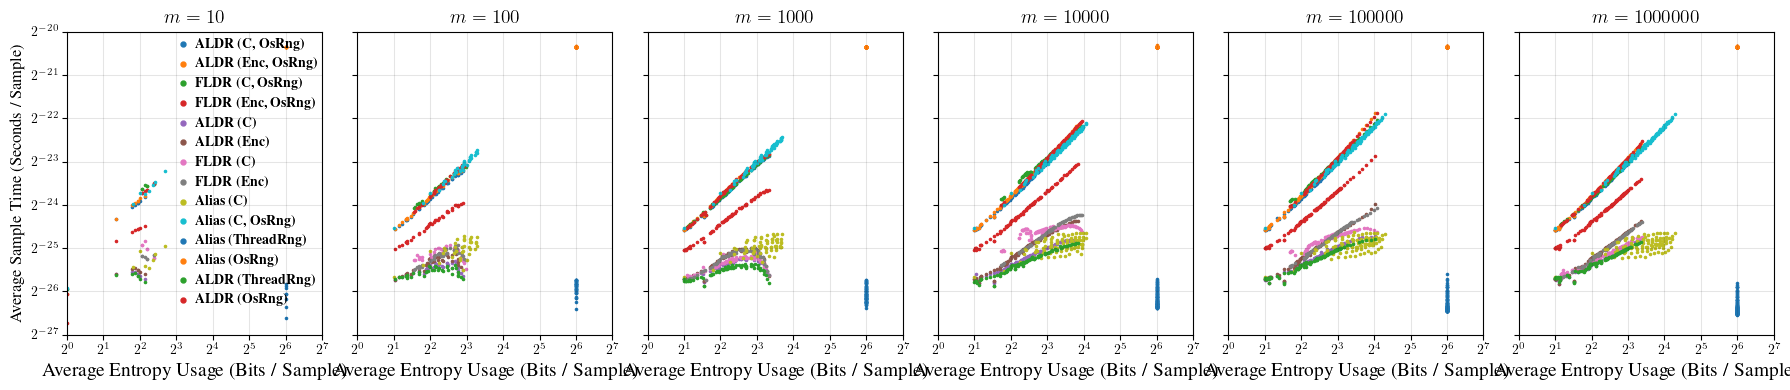

In [12]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in method_names]
    for i in range(len(methods)):
        ax.scatter(*zip(*((d[5],d[4]) for d in C if d[1] == methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=2)
    ax.set_ylim([2**-27, 2**-20])
    ax.set_xlim([2**0, 2**7])

    ax.set_xlabel('Average Entropy Usage (Bits / Sample)', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Average Sample Time (Seconds / Sample)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(.35, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

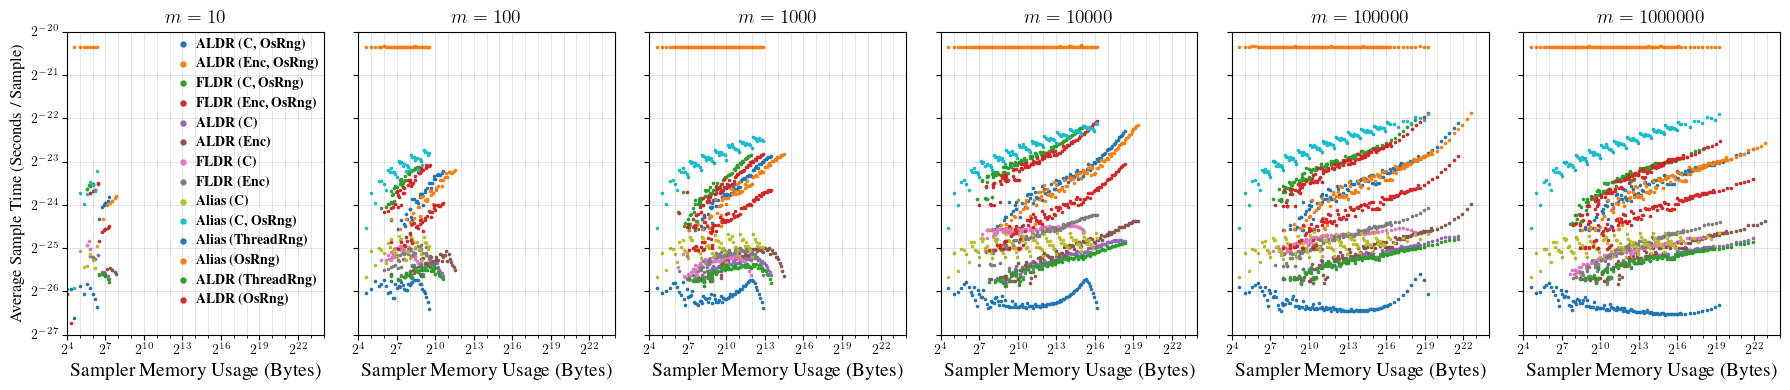

In [13]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in method_names]
    for i in range(len(methods)):
        ax.scatter(*zip(*((d[6],d[4]) for d in C if d[1] == methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=2)
    ax.set_ylim([2**-27, 2**-20])
    ax.set_xlim([2**4, 2**24])

    ax.set_xlabel('Sampler Memory Usage (Bytes)', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Average Sample Time (Seconds / Sample)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(.35, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

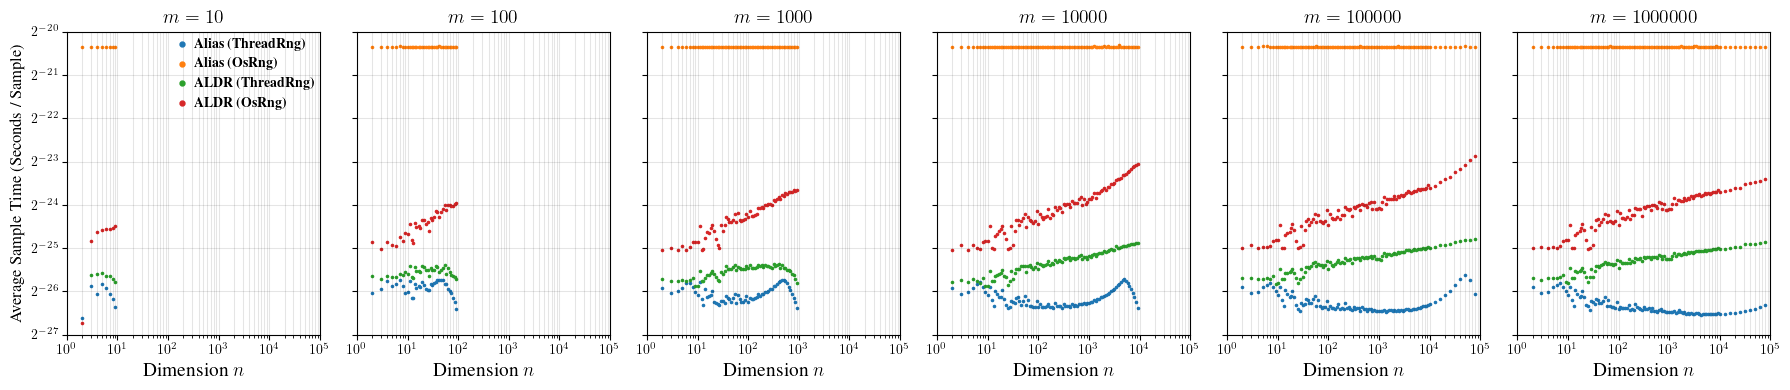

In [14]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in rust_method_names]
    for i in range(len(rust_methods)):
        ax.scatter(*zip(*((getn(d[0]),d[4]) for d in C if d[1] == rust_methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=10)
    ax.set_ylim([2**-27, 2**-20])
    ax.set_xlim([10**0, 1*10**5])

    ax.set_xlabel('Dimension $n$', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Average Sample Time (Seconds / Sample)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(.35, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(1, 10)*.1, numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)

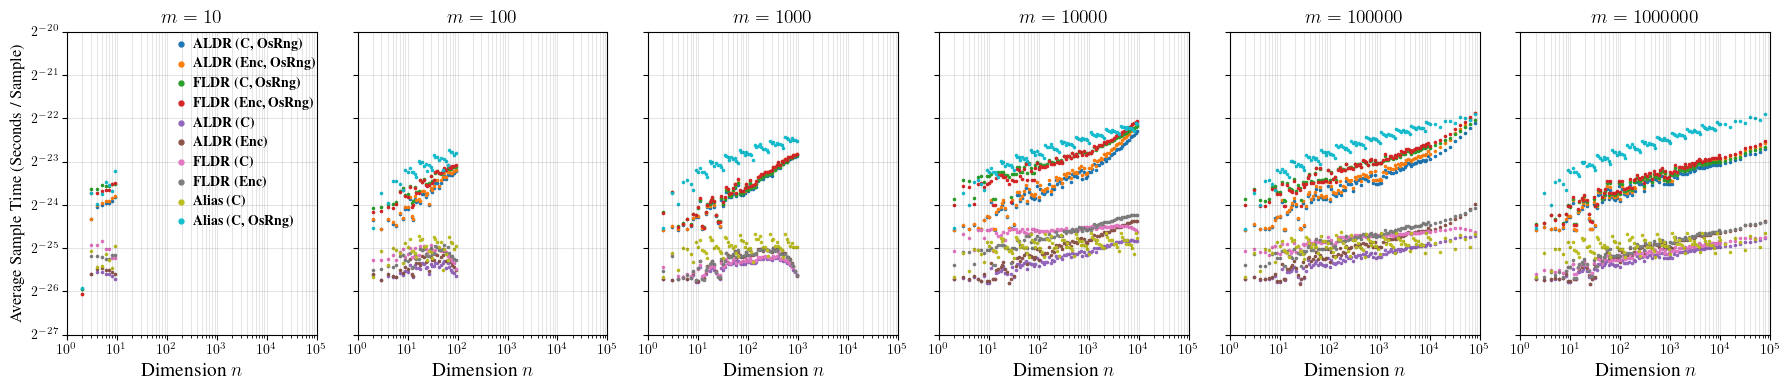

In [15]:
fig, axes = plt.subplots(ncols=len(selections))
for i, M in enumerate(Ms_plot):

    ax = axes[i]
    C = [d for d in data if d[0].endswith(f'.{M}.{seed}.dist')]

    colors = [ax.scatter([], [], marker='.', s=50,
        label=r'\textbf{%s}' % (method_name,)).get_facecolors()[0] for method_name in c_method_names]
    for i in range(len(c_methods)):
        ax.scatter(*zip(*((getn(d[0]),d[4]) for d in C if d[1] == c_methods[i])), marker='.', s=10, color=colors[i])

    ax.set_yscale('log', base=2)
    ax.set_xscale('log', base=10)
    ax.set_ylim([2**-27, 2**-20])
    ax.set_xlim([10**0, 1*10**5])

    ax.set_xlabel('Dimension $n$', fontsize=14)
    ax.set_title('$m = %d$' % (M,), fontsize=14)

axes[0].set_ylabel('Average Sample Time (Seconds / Sample)', fontsize=12)
axes[0].legend(
    loc='upper left', framealpha=0, handletextpad=-.1,
    bbox_to_anchor=(.35, 1.02))

for i in range(1, len(selections)):
    axes[i].set_yticklabels([])

for i in range(len(selections)):
    axes[i].yaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].yaxis.set_major_locator(ticker.LogLocator(base=2, subs=[1], numticks=10))
    axes[i].yaxis.set_minor_locator(ticker.LogLocator(base=2, subs=[1], numticks=100))
    
    axes[i].xaxis.set_minor_formatter(ticker.NullFormatter())
    axes[i].xaxis.set_major_locator(ticker.LogLocator(base=10, subs=[1], numticks=10))
    axes[i].xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(1, 10)*.1, numticks=100))

    axes[i].grid(which='both', color='black', alpha=.1, linestyle='-')

fig.set_size_inches(*size_inches)
fig.set_tight_layout(True)